In [1]:
import numpy as np
import jax_tqdm as jtqdm
import jax.numpy as jnp
from jax import jit, vmap, grad
import jax.lax as lax
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import time
import pickle
import numpyro, jax
import numpyro.distributions as dists
from numpyro.infer.util import initialize_model
from glob import glob
from astropy.io import fits

import WR_Geom_Model as gm
import WR_binaries as wrb

### --- INFERENCE --- ###  
# n = 256     # standard
n = 600     # VISIR
# n = 898     # JWST
@jit
def smooth_histogram2d(particles, weights, stardata):
    im_size = n
    
    x = particles[0, :]
    y = particles[1, :]
    
    xbound, ybound = jnp.max(jnp.abs(x)), jnp.max(jnp.abs(y))
    bound = jnp.max(jnp.array([xbound, ybound])) * (1. + 2. / im_size)
    
    xedges, yedges = jnp.linspace(-bound, bound, im_size+1), jnp.linspace(-bound, bound, im_size+1)
    return gm.smooth_histogram2d_base(particles, weights, stardata, xedges, yedges, im_size)
@jit
def smooth_histogram2d_w_bins(particles, weights, stardata, xbins, ybins):
    im_size = n
    return gm.smooth_histogram2d_base(particles, weights, stardata, xbins, ybins, im_size)

In [70]:
pscale = 1000 * 23/512 # mas/pixel, (Yinuo's email said 45mas/px, but I think the FOV is 23x23 arcsec for a 512x512 image?)
vlt_years = [2016, 2017, 2018, 2024]
vlt_data = {}
flattened_vlt_data = {}
directory = "Data/VLT"
fnames = glob(directory + "/*.fits")

for i, fname in enumerate(fnames):
    
    data = fits.open(fname)[0].data
    
    length = data.shape[0]
    
    X = jnp.linspace(-1., 1., length) * pscale * length/2 / 1000
    Y = X.copy()
    
    xs, ys = jnp.meshgrid(X, Y)
    
    data = jnp.array(data)
    
    data = data - jnp.percentile(data, 84)
    data = data/jnp.max(data)
    data = jnp.maximum(data, 0)
    data = jnp.abs(data)**0.5 
    
    vlt_data[vlt_years[i]] = data
    flattened_vlt_data[vlt_years[i]] = data.flatten()

# big_flattened_data = jnp.concatenate([flattened_vlt_data[year] for year in vlt_years])
xbins = X
ybins = Y

print("Data loaded in well.")

Data loaded in well.


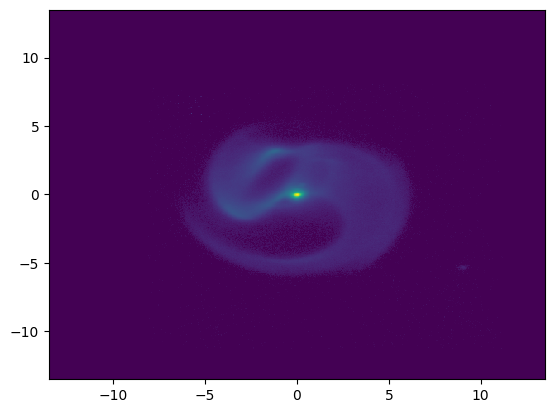

In [72]:
plt.pcolormesh(xs, ys, vlt_data[2016])

In [125]:
apep = wrb.apep.copy()
samp_particles, samp_weights = gm.dust_plume(apep)
_, _, samp_H = smooth_histogram2d_w_bins(samp_particles, samp_weights, apep, xbins, ybins)
samp_H = gm.add_stars(xbins, ybins, samp_H, apep)
flat_samp_H = samp_H.flatten()


sim_data = flat_samp_H + abs(np.random.normal(0, 0.08, len(flat_samp_H)))

In [136]:
year = 2024

# data = flattened_vlt_data[year]
data = sim_data

a = 0.06
b = 0.01
err = np.sqrt(a * data + b**2)



year_params = apep.copy()
year_params['phase'] -= (2024 - year) / apep['period']
samp_particles, samp_weights = gm.dust_plume(year_params)
_, _, samp_H = smooth_histogram2d_w_bins(samp_particles, samp_weights, year_params, xbins, ybins)
samp_H = gm.add_stars(xbins, ybins, samp_H, year_params)
flat_samp_H = samp_H.flatten()



chi_sq = np.sum(((data - flat_samp_H) / err)**2) / (len(flat_samp_H) - 10 - 1)
print(chi_sq)

0.9835538982608045


In [124]:
sim_data

Array([-0.08119727,  0.07647399, -0.03183384, ..., -0.15643682,
       -0.06081852,  0.0277851 ], dtype=float64)